In [1]:
import subprocess
import os
import sys

import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../')
from utils import *

# path with scPerturb data (replace accordingly)
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
# temp path
SDIR = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'
# output from snakemake (tables)
table_path = '/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/'
# path for figures
figure_path = '../figures/'
# path for supplemental figures and tables
supp_path = '../supplement/'

In [2]:
# get indecs of dataset
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name.split('.h5')[0]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
del h5_files['gene_scores']
del h5_files['peak_bc']
del h5_files['ChromVar']
del h5_files['LSI_embedding']
del h5_files['markerpeak_target']

del h5_files['XieHon2017']
datasets = list(h5_files.keys())
# print(len(datasets))

In [3]:
pairs_datasets = {}
estats_datasets = {}
estats_control_datasets = {}
for key in h5_files.keys():
    if not os.path.exists(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv'):
        continue
    # load pca and bulk pca pairwise distances
    pwd = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)
    if 'control' not in pwd.index or len(pwd.index)<3:
        continue
    
    # derive basic statistics
    sigmas = np.diag(pwd)
    deltas = pwd
    
    estats = 2 * deltas - sigmas - sigmas[:, np.newaxis]
    estats = cluster_matrix(estats, 'both')
    estats_control = estats.loc[:, 'control']
    
    # select unique combination pairs (since estats matrix is symmetric)
    U = pd.DataFrame(np.triu(estats, k=0), index=estats.index, columns=estats.columns)
    P = U.stack().reset_index()
    pairs = P[P[0]!=0]
    assert len(pairs[pairs[0]!=0]) * 2 + len(estats) == len(P)
    pairs['dataset'] = key
    
    estats_control_datasets[key] = estats_control
    estats_datasets[key] = estats
    pairs_datasets[key] = pairs

In [4]:
# aggregate
pairs_all = pd.concat(pairs_datasets)
pairs_all['E-statistic'] = ['perturbed-unperturbed' if 'control' in str(x)+str(y) else 'perturbed-perturbed' for x,y in zip(pairs_all.level_0, pairs_all.level_1)]
pairs_all['pair'] = [f'{x}-{y}' for x,y in zip(pairs_all.level_0, pairs_all.level_1)]
# prettier names
pairs_all['dataset_pretty'] = [x.replace('TAP_SCREEN__', '') for x in pairs_all.dataset]
pairs_all['dataset_pretty'] = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in pairs_all.dataset_pretty]
pairs_all['dataset_pretty'] = [x.replace('_', ' ') for x in pairs_all.dataset_pretty]

# Fig4B

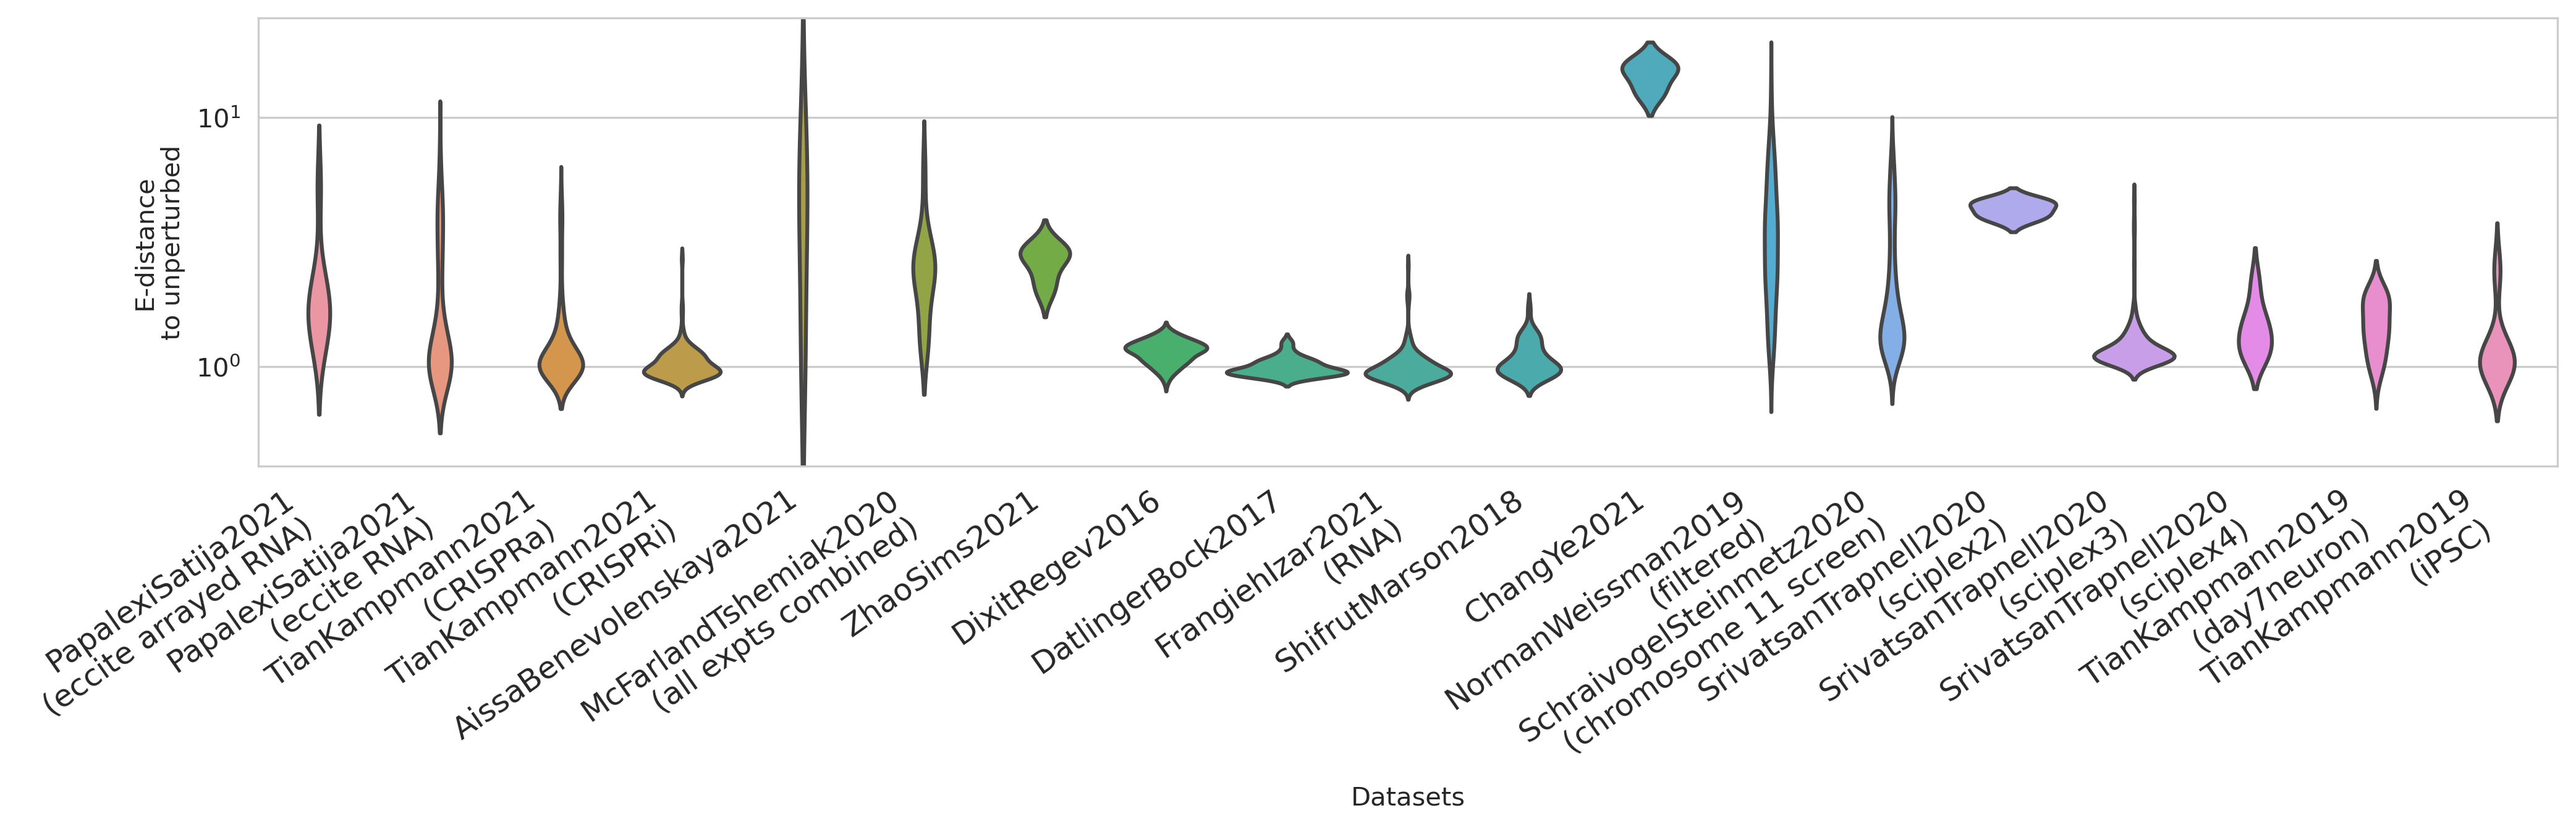

In [5]:
scale = 0.8
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 4*scale], dpi=300)
pairs_all['tmp'] = np.log10(pairs_all[0]+1)
sns.violinplot(data=pairs_all[pairs_all['E-statistic']=='perturbed-unperturbed'], x='dataset_pretty', y='tmp', width=1, inner=None)
pl.xticks(rotation=35, ha='right', fontsize=12)
pl.ylabel('E-distance\nto unperturbed')
pl.xlabel('Datasets')
# pl.xlim([-1.5,5])

# log scale y ticks
from matplotlib import ticker as mticker
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(0, 2)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_ylim([-0.4, 1.4])

pl.savefig(f'{figure_path}/Fig4B.pdf', bbox_inches='tight')
pl.show()

# Fig4C

In [6]:
key = 'NormanWeissman2019_filtered'
pairs = pairs_datasets[key]
estats = estats_datasets[key]
estats_control = pd.DataFrame(estats.loc[:, 'control'])
estats_control.columns=['E-statistic']

In [7]:
indices = list(estats_control['E-statistic'].sort_values().index)
N = 3
top=indices[-N:]
bot=indices[:N]
strong = list(estats_control.index[estats_control['E-statistic']>2]) + ['control']

In [8]:
# add e-test results
tab = pd.read_csv(f'{table_path}etest_{key}_tables.csv', index_col=0)
if 'pvalue' not in estats_control.columns:
    estats_control = pd.merge(estats_control, tab, left_index=True, right_index=True, how='left')
estats_control['significant_adj_'] =  estats_control['significant_adj']
estats_control.loc['control', 'significant_adj_'] = 'Unperturbed'

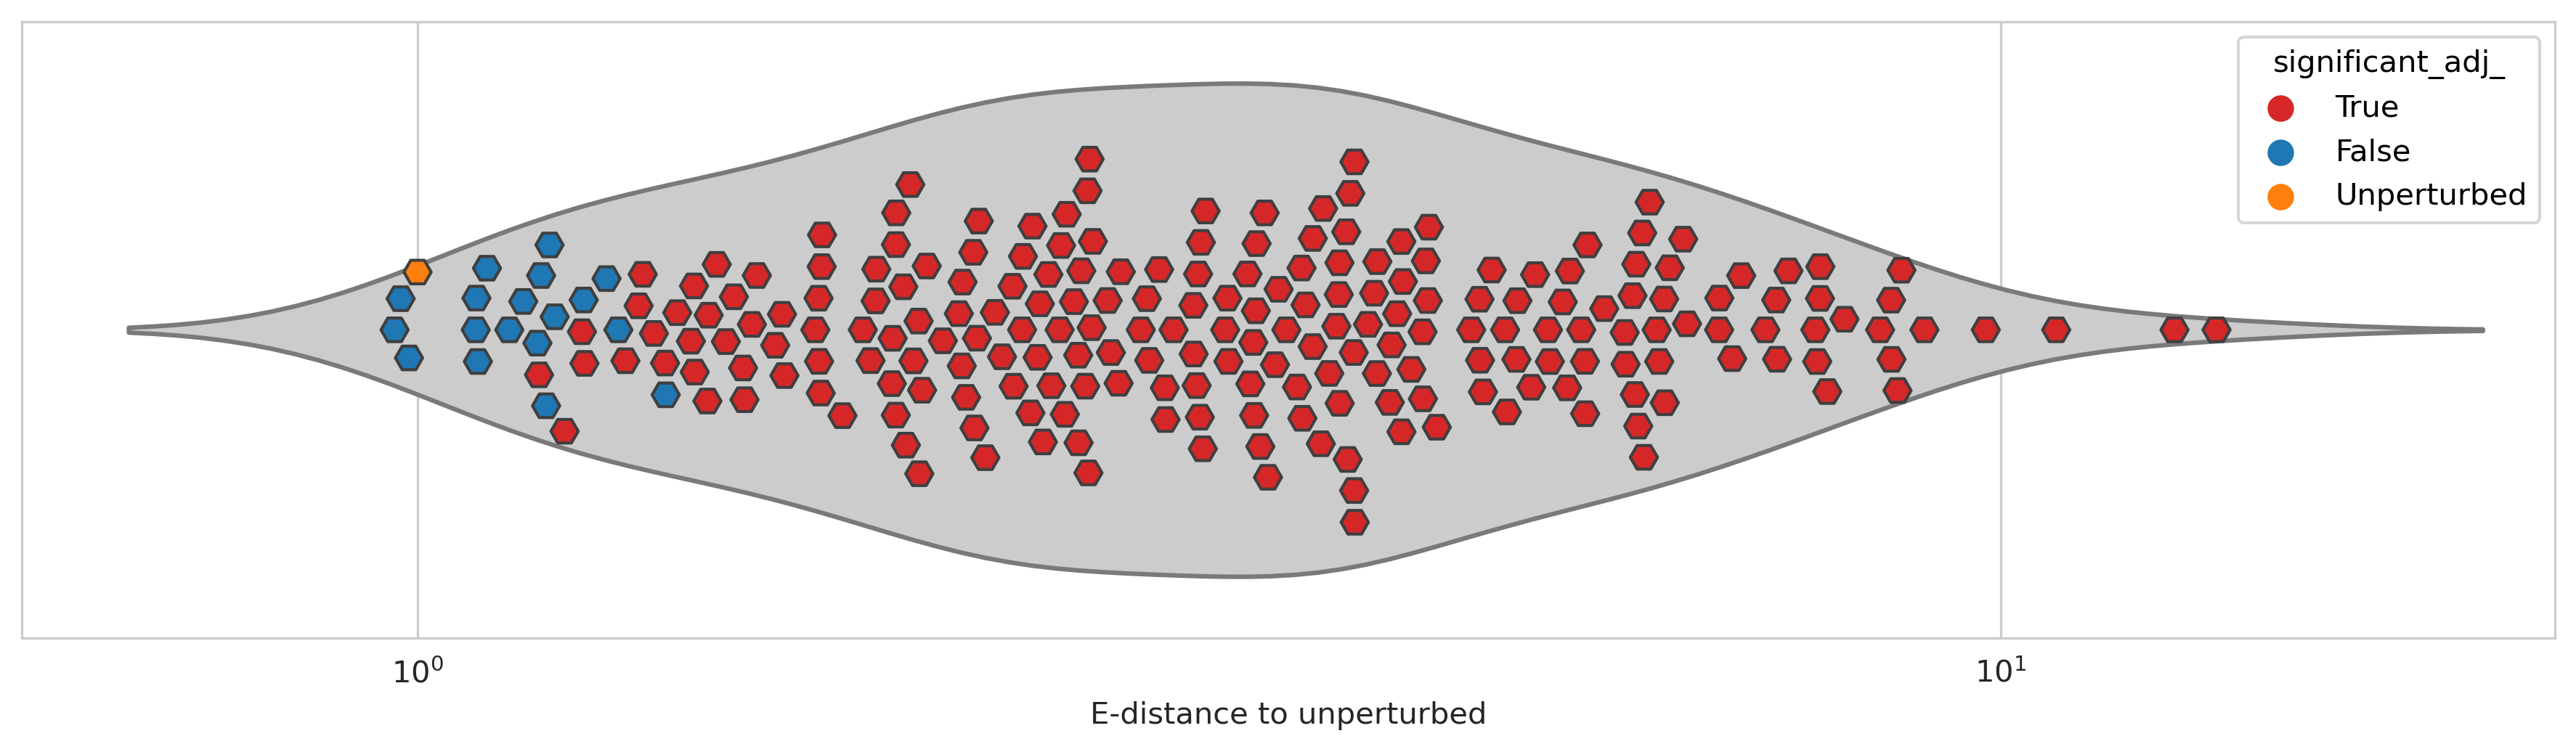

In [9]:
scale=0.75
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 5*scale], dpi=300)  # [8*scale, 5*scale]
estats_control['tmp'] = np.log10(estats_control['E-statistic']+1)
sns.violinplot(data=estats_control, x='tmp', inner=None, color=".8", width=0.8)
ax = sns.swarmplot(data=estats_control, x=estats_control['tmp'], y=['']*len(estats_control), size=9, 
                   marker="H", edgecolors='white', linewidth=1, hue='significant_adj_', palette=['tab:red', 'tab:blue', 'tab:orange'])
pl.xlabel('E-distance to unperturbed')

# log scale x ticks
from matplotlib import ticker as mticker
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
xmin, xmax = ax.get_xlim()
tick_range = np.arange(0, xmax)
ax.xaxis.set_ticks(tick_range)
ax.xaxis.set_ticks([np.log10(x+1) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_xlim([-0.25, 1.35])
pl.savefig(f'{figure_path}/Fig4C.pdf', bbox_inches='tight')
pl.show()

# Fig4D

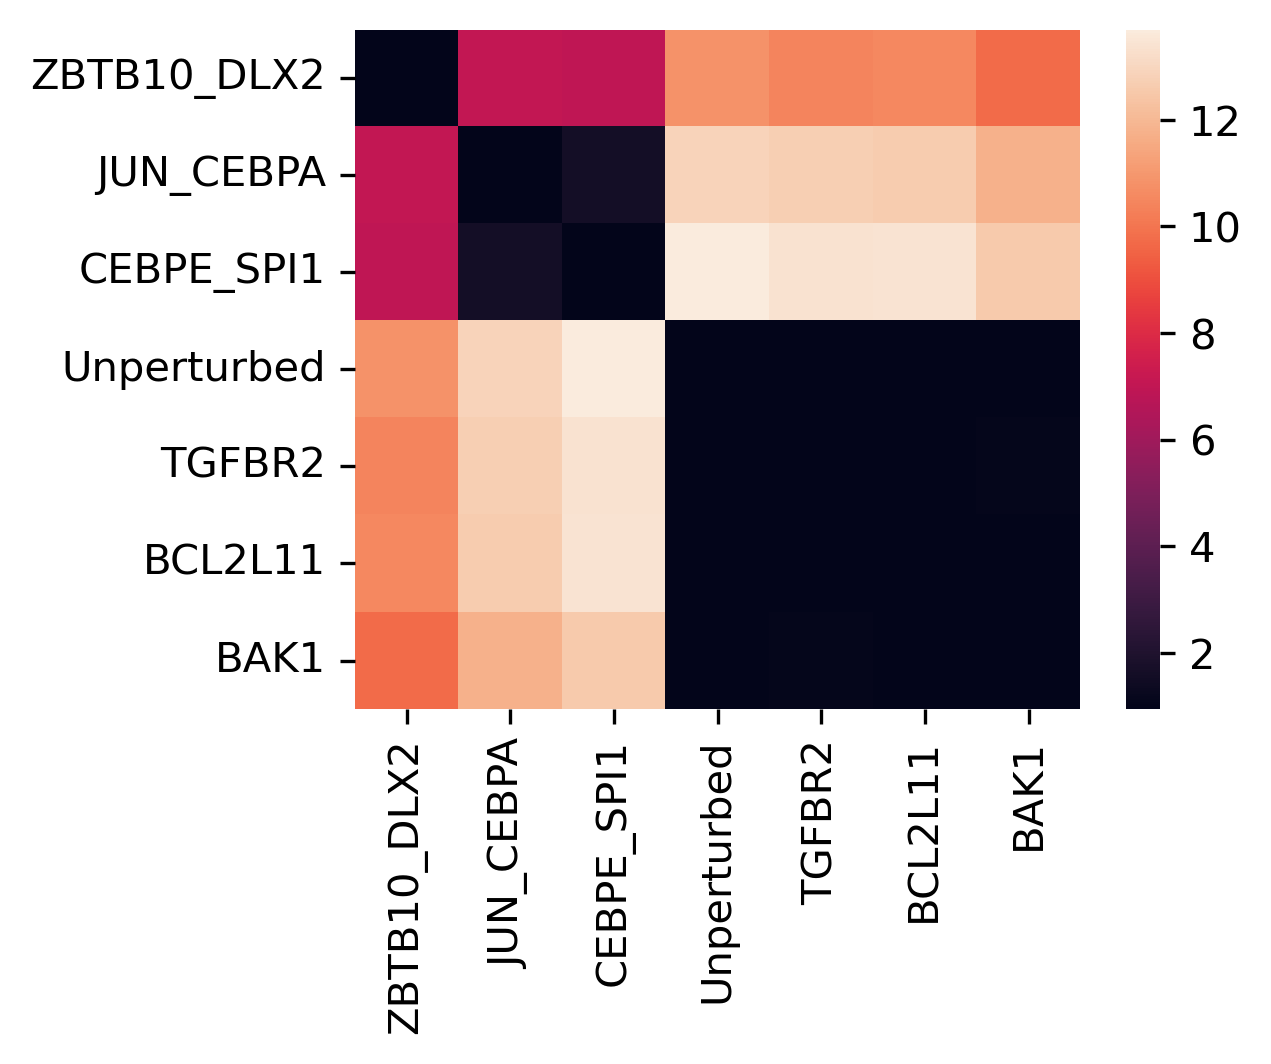

In [10]:
scale=0.3
pl.subplots(figsize=[13*scale,10*scale], dpi=300)
conds = top + ['control'] + bot
sub = estats.loc[conds, conds] + 1
sub = sub.rename({'control': 'Unperturbed'}, axis=1).rename({'control': 'Unperturbed'}, axis=0)
sns.heatmap(sub, robust=False)
pl.savefig(f'{figure_path}/Fig4D.pdf', bbox_inches='tight')
pl.show()

# Fig4E

In [11]:
adata = sc.read(f'{SDIR}tmp_data_{key}.h5')

In [12]:
sdata = adata[np.isin(adata.obs.perturbation, top+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)

# ['bot', 'control', 'top']
sdata.uns['group_colors'] = ['tab:grey', 'tab:red']  # ['tab:blue', 'tab:grey', 'tab:red']
from matplotlib.cm import get_cmap
colors_top = {g: get_cmap('Reds')((i+1)/N) for i, g in enumerate(top)}
colors_bot = {g: get_cmap('Blues')((i+1)/N) for i, g in enumerate(bot)}
colors_control = {'control': 'tab:grey'}
colors = {**colors_top, **colors_bot, **colors_control}
sdata.uns['perturbation_colors'] = [colors[g] for g in np.sort(pd.unique(sdata.obs.perturbation))]

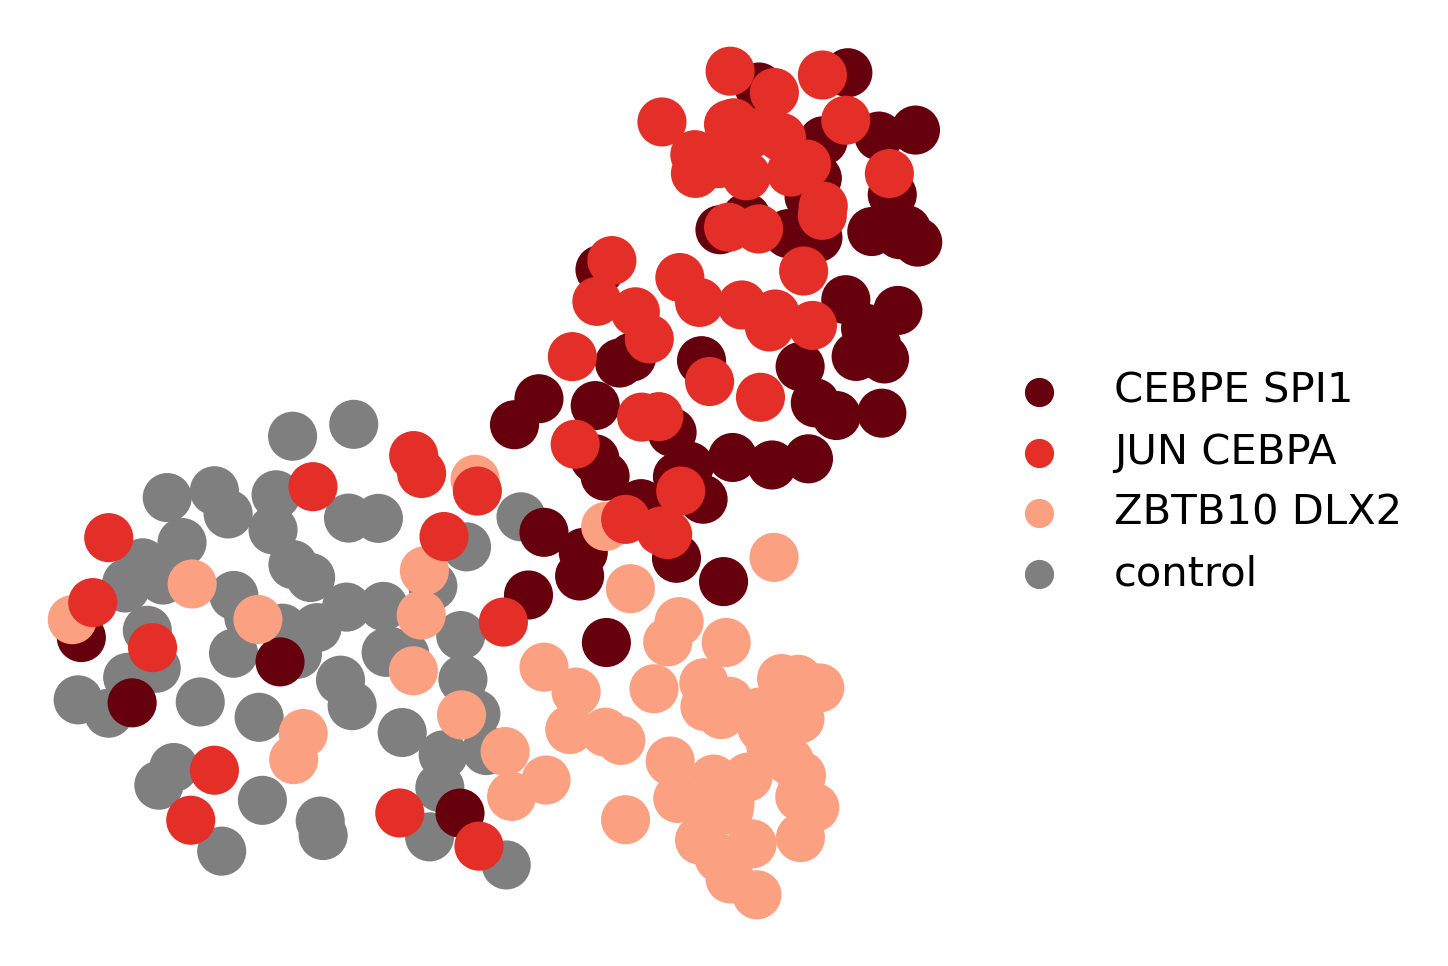

In [13]:
scv.pl.scatter(sdata, color='perturbation', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='')
pl.savefig(f'{figure_path}/Fig4E_top.pdf', bbox_inches='tight')
pl.show()

In [14]:
sdata = adata[np.isin(adata.obs.perturbation, bot+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)

# ['bot', 'control', 'top']
sdata.uns['group_colors'] = ['tab:blue', 'tab:grey']  # ['tab:blue', 'tab:grey', 'tab:red']
from matplotlib.cm import get_cmap
colors_top = {g: get_cmap('Reds')((i+1)/N) for i, g in enumerate(top)}
colors_bot = {g: get_cmap('Blues')((i+1)/N) for i, g in enumerate(bot)}
colors_control = {'control': 'tab:grey'}
colors = {**colors_top, **colors_bot, **colors_control}
sdata.uns['perturbation_colors'] = [colors[g] for g in np.sort(pd.unique(sdata.obs.perturbation))]

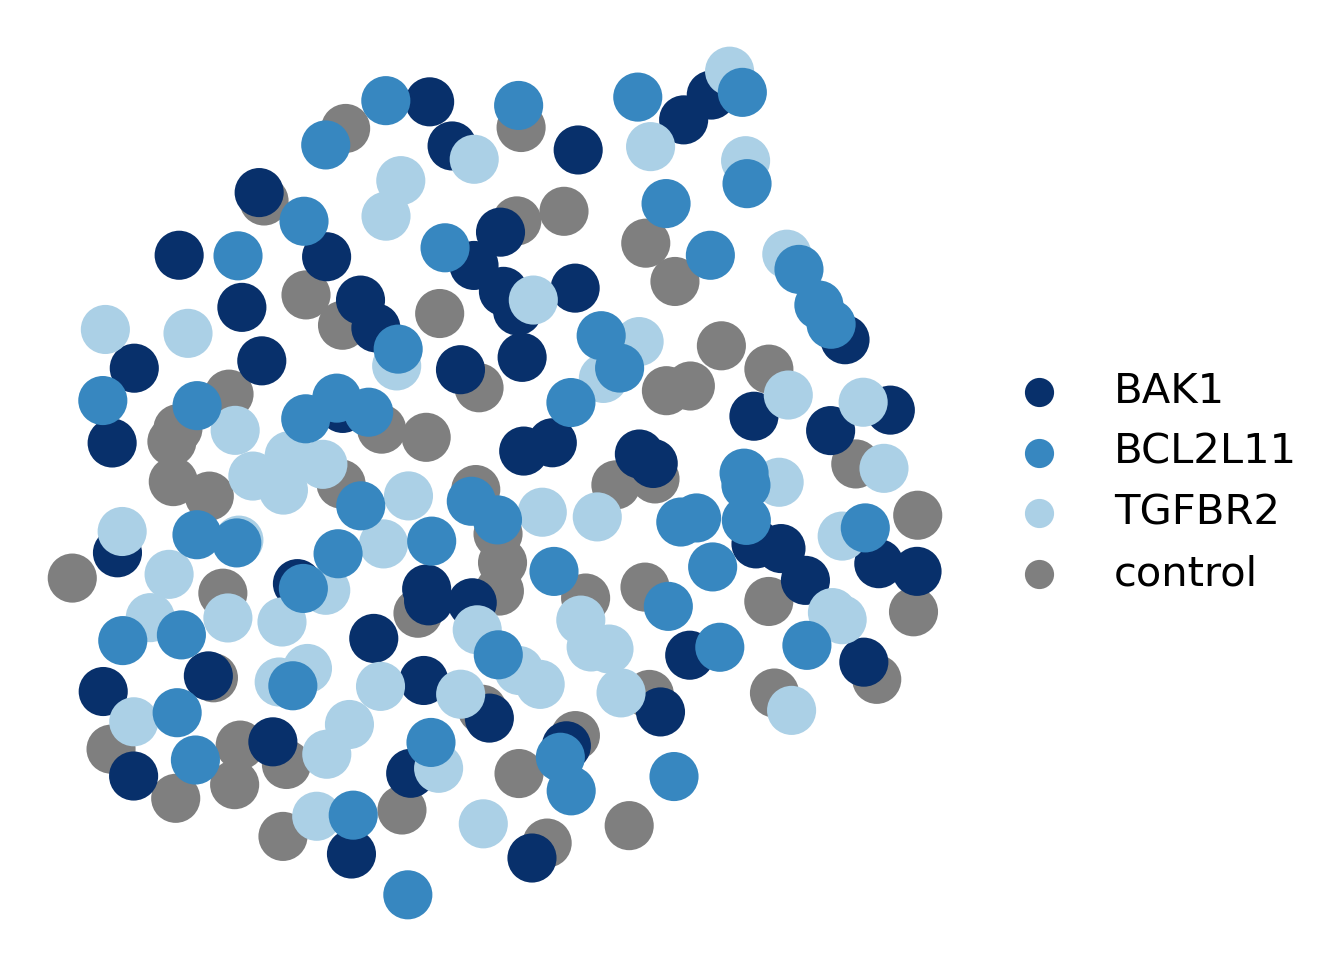

In [15]:
scv.pl.scatter(sdata, color='perturbation', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='')
pl.savefig(f'{figure_path}/Fig4E_bottom.pdf', bbox_inches='tight')
pl.show()

# Supplement

## SuppTab4

In [16]:
res={}
for key in h5_files.keys():
    file = f'{table_path}/etest_{key}_tables.csv'
    if not os.path.exists(file):
        continue
    # load test results
    t = pd.read_csv(file, index_col=0)
    res[key] = t

In [17]:
tab = pd.concat(res).reset_index()
tab.columns=['dataset', 'perturbation', 'edist_to_unperturbed', 'pvalue', 'significant', 'pvalue_adj', 'significant_adj']
tab.to_csv(f'{supp_path}/SuppTab4.csv')

In [18]:
tab.head()

,dataset,perturbation,edist_to_unperturbed,pvalue,significant,pvalue_adj,significant_adj
0,PapalexiSatija2021_eccite_arrayed_RNA,ATF2,19.341576,0.00,True,0.00,True
1,PapalexiSatija2021_eccite_arrayed_RNA,CAV1,37.631357,0.00,True,0.00,True
2,PapalexiSatija2021_eccite_arrayed_RNA,ETV7,4.753141,0.06,False,0.06,False
3,PapalexiSatija2021_eccite_arrayed_RNA,IFNGR1,112.180316,0.00,True,0.00,True
4,PapalexiSatija2021_eccite_arrayed_RNA,IRF1,12.063627,0.00,True,0.00,True


## SuppFig4C

In [19]:
key = 'NormanWeissman2019_filtered'
tab = pd.read_csv(f'{table_path}/etest_{key}_tables.csv', index_col=0)

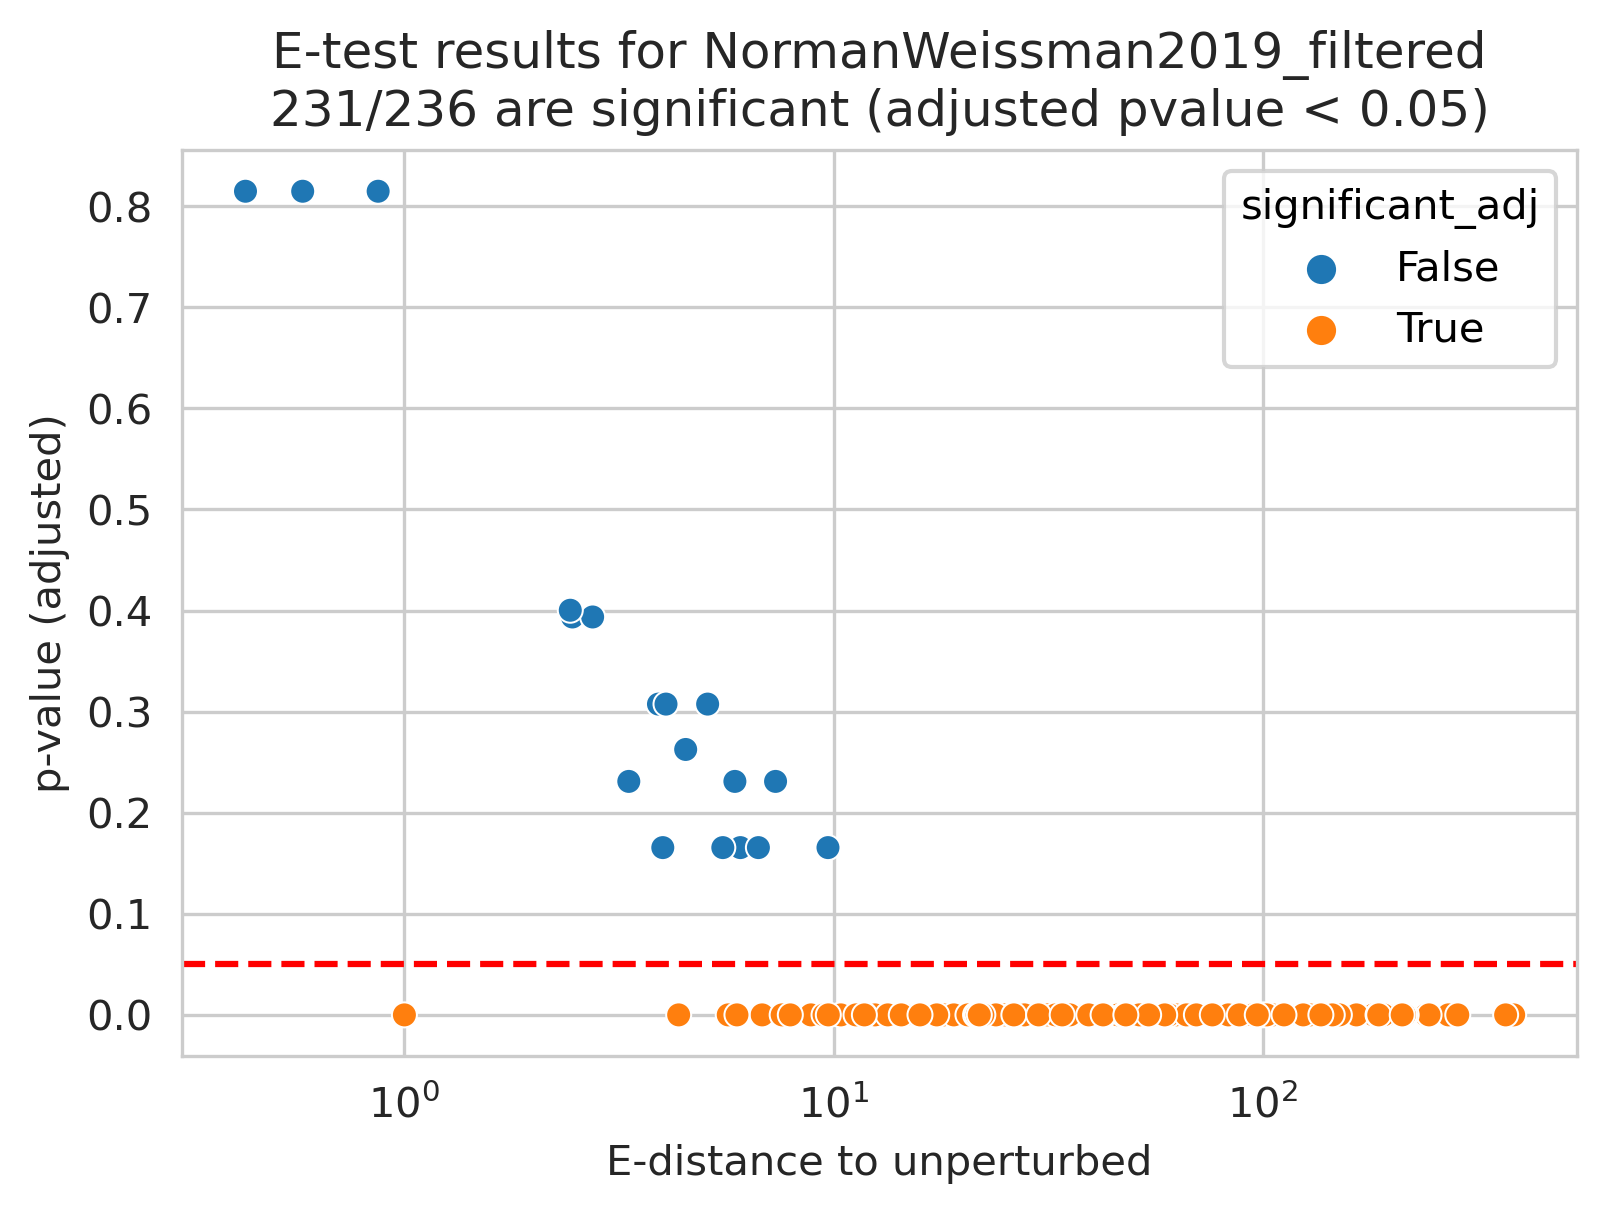

In [20]:
pseudocount = 1
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(dpi=300)
sns.scatterplot(data=tab, x=tab.edist+pseudocount, y=tab.pvalue_adj, hue='significant_adj')
pl.xlabel(f'E-distance to unperturbed')
sig = np.sum(tab['significant'])
total = len(tab)-1
pl.title(f'E-test results for {key}\n{sig}/{total} are significant (adjusted pvalue < 0.05)')
pl.xscale('log')
pl.ylabel('p-value (adjusted)')
pl.axhline(0.05, c='r', linestyle='--')
pl.savefig(f'{supp_path}/SuppFig4B.pdf', bbox_inches='tight')
pl.show()

## SuppFig4D

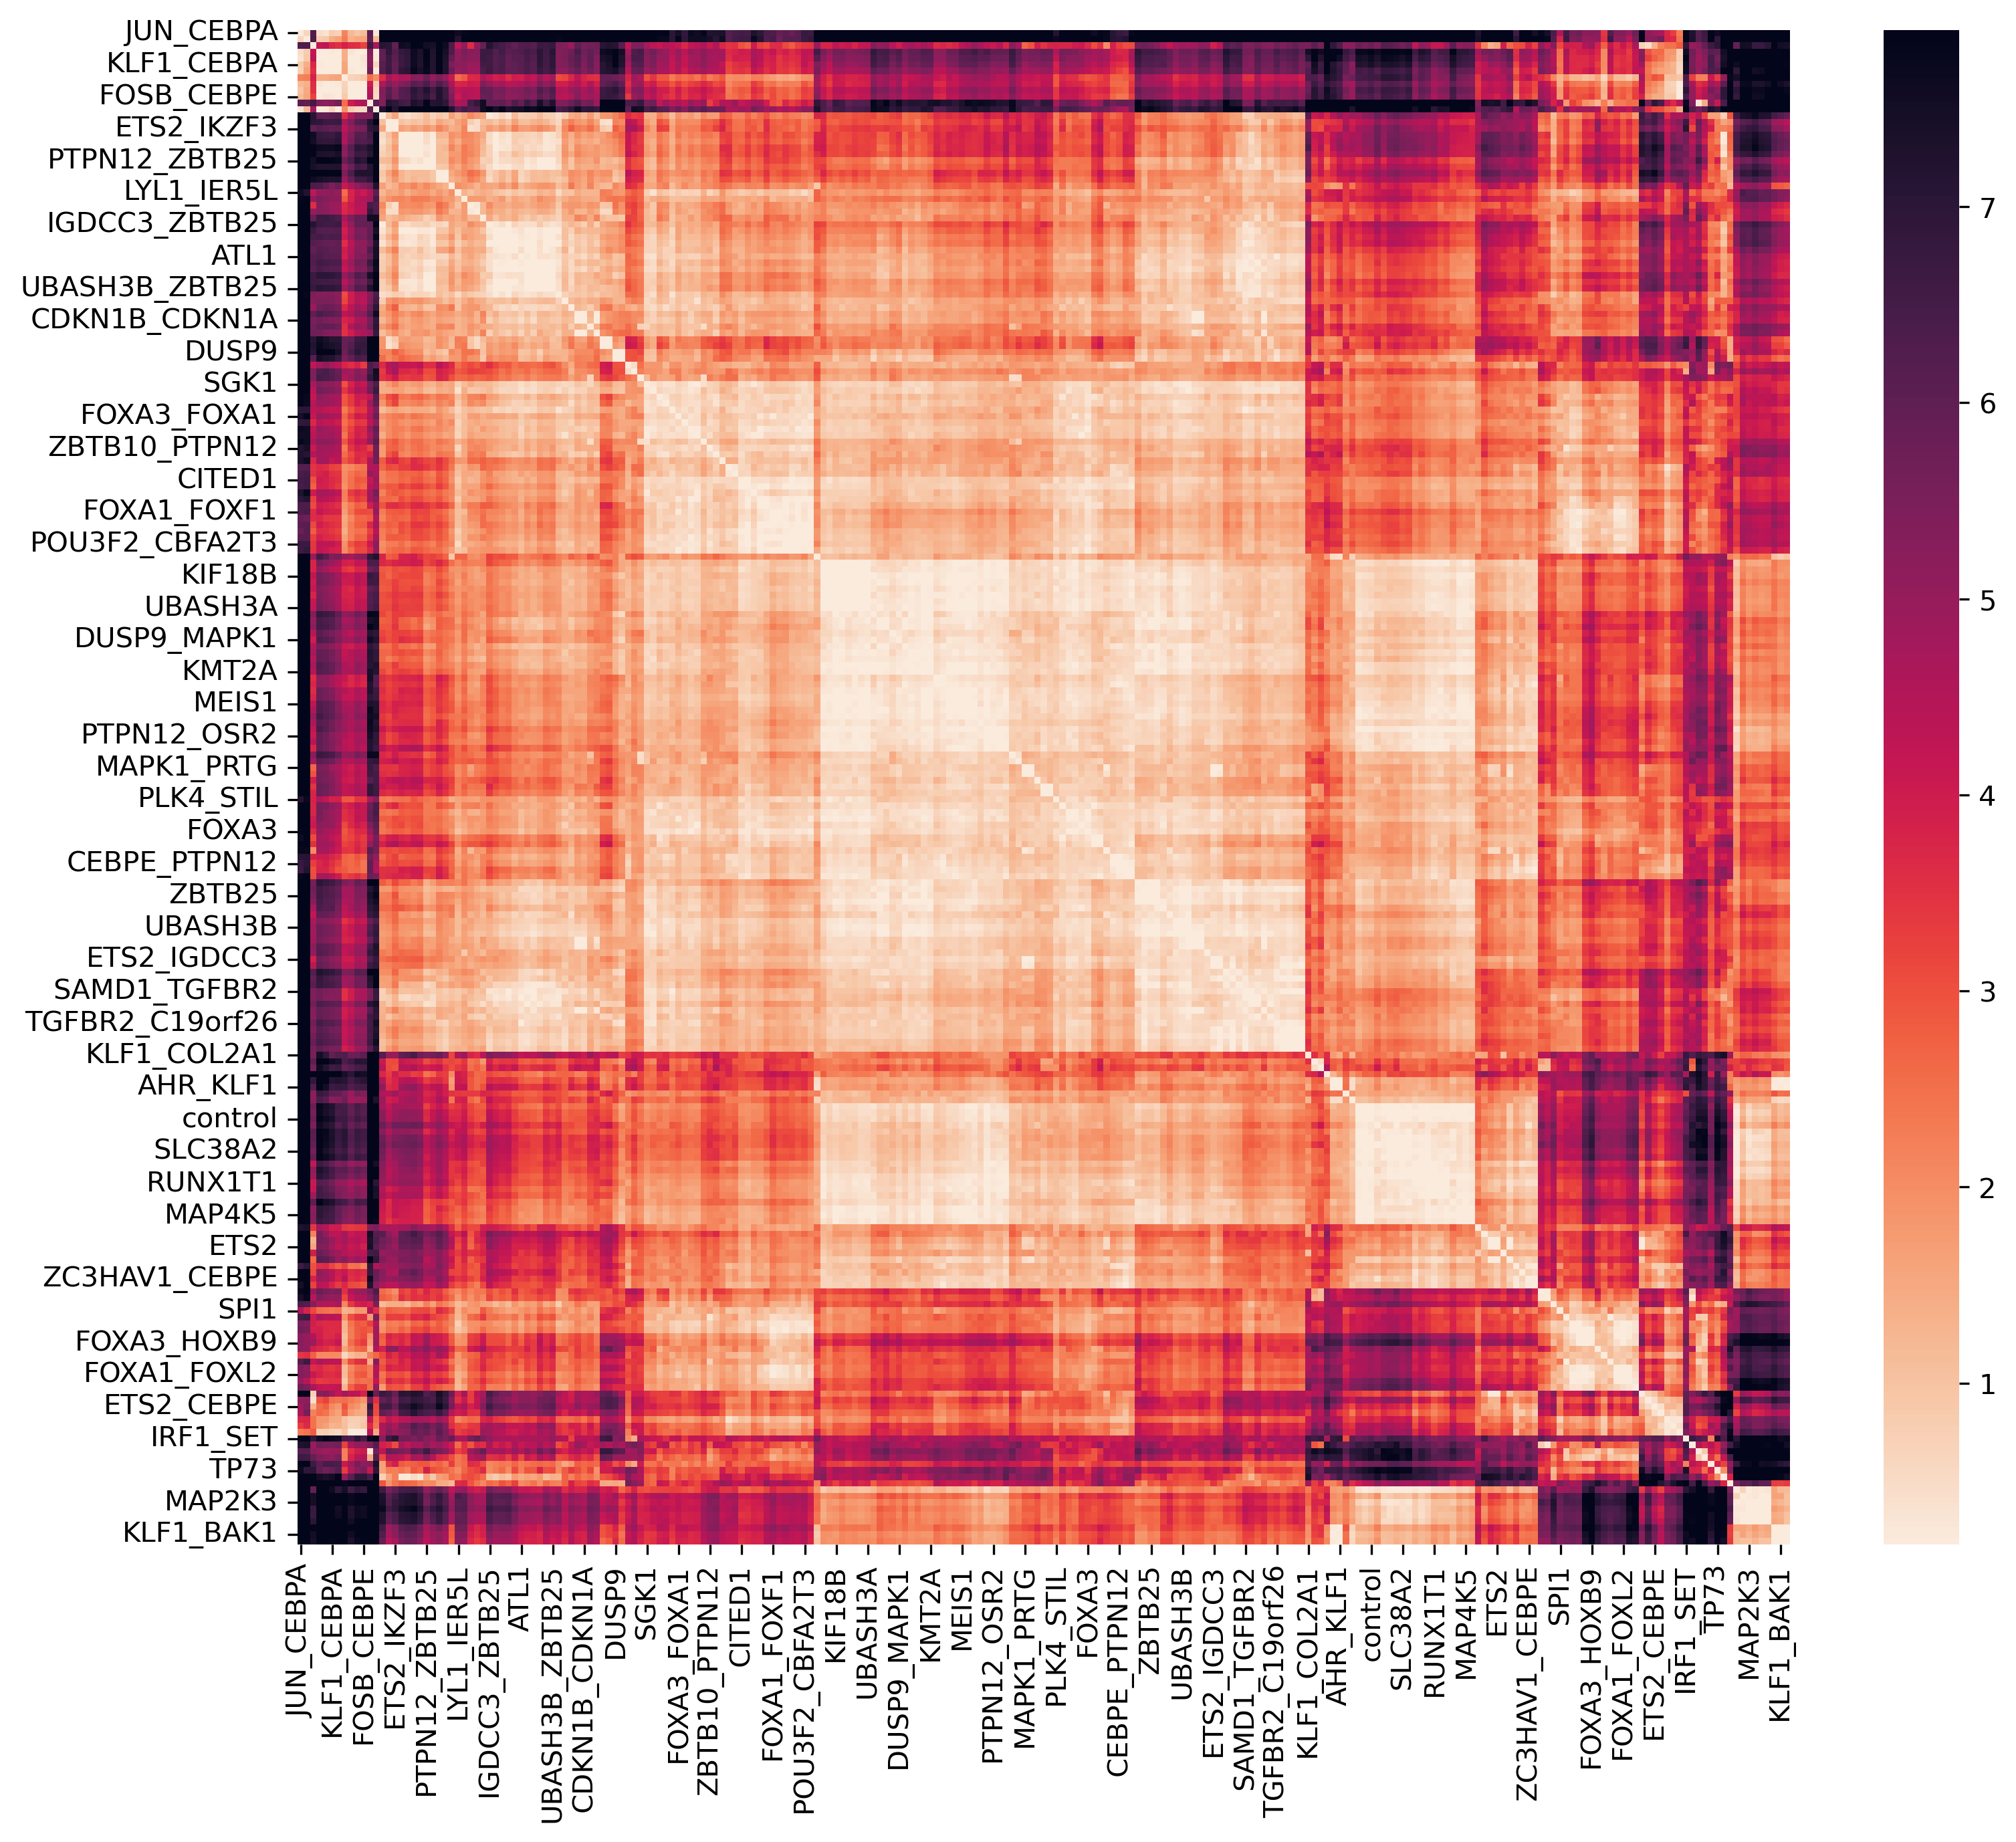

In [21]:
pl.figure(figsize=[12,10], dpi=300)
sns.heatmap(estats, robust=True, cmap='rocket_r')
pl.savefig(f'{supp_path}/SuppFig4D.pdf', bbox_inches='tight')
pl.show()